# Laboratory 1: Working with Deep Models

This laboratory aims to gain practice with Deep Models, in particular with Computer Vision models.
- In the first exercise I defined a training pipeline and trained a simple MLP and more complex ResNet models on MNIST and CIFAR-10 dataset.
- In the second exercise I experimented with Class Activation Maps, using them to visualize the areas of the image that are most relevant for the classification and also adapted them to perform localization of digits in the image.

All the code is available in my [Github repo](https://github.com/ciodar/deep-labs/tree/main/lab1)

## Exercise 1: Warming Up
In this series of exercises I duplicated some of the results of the ResNet paper

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

Before doing so, I will detail the training pipeline I defined, which is used in all the exercises by training a simple MLP on MNIST dataset.

### Training pipeline
I set up a simple pipeline to train and evaluate models, and experimented logging using [Weights and Biases](https://wandb.ai/site) (WandB).

In [1]:
# Start with some standard imports.
from os import chdir
from random import randrange
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import wandb
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torchvision.transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from torchvision.utils import draw_bounding_boxes

from data_loader import SubsetDataset
from trainer import Trainer,plot_curves
from models.resnet import ResNetForClassification,ResNet


# some utility functions
# sets current directory as the notebook's parent
def make_paths_relative_to_root():
    """Always use the same, absolute (relative to root) paths
    which makes moving the notebooks around easier.
    """
    top_level = Path(__file__).parent
    chdir(top_level)

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
        if img.shape[0] == 1:
            img = img.repeat(3,1,1)
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#Global setting
BATCH_SIZE = 128
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#### Data preparation
I define a custom class `SubsetDataset`, which wraps a `Subset` into a `Dataset` object. This will be useful when we'll want to use a different transformation from training and validation on CIFAR-10.

For MNIST dataset I used the following approach
- Data is normalized using the mean and standard deviation of the dataset and then resized to 32x32, to mantain the same size of CIFAR-10. This resize was also used in the original LeNet paper for convolutional networks, as it helps to enlarge the receptive field of convolutional layers.
- 10% of training data is held out and used for validation.

In [2]:
# Load MNIST train dataset
dataset = datasets.MNIST(root='/data',train=True,download=True)
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # antialias required to not throw a warning
    transforms.Resize(32,antialias=False)
])
# Split train into train and validation. We use 10% of the training data as validation
val_size = int(0.1*len(dataset))
I = np.random.permutation(len(dataset))

mnist_train = SubsetDataset(Subset(dataset, I[val_size:]),transform)
mnist_val = SubsetDataset(Subset(dataset, I[:val_size]),transform)

train_data_loader = DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True)
valid_data_loader = DataLoader(mnist_val,batch_size=BATCH_SIZE)

To verify that the data is loaded correctly, we can plot some images. I defined a `show` function to do that.

Images shape: (128, 1, 32, 32)
Labels shape: (128,)


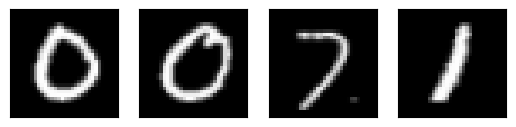

In [3]:
dataiter = iter(train_data_loader)
images,labels = next(dataiter)
print(f'Images shape: {tuple(images.shape)}\nLabels shape: {tuple(labels.shape)}')
# show images
show(images[0:4])

#### WandB logging

I used this laboratory also to experiment with WandB, which is used to log every experiment.
I create a new project, [lab-1-resnets](https://wandb.ai/dla-darcio/lab-1-resnets) and defined the logic to
- Log train and validation loss and accuracy during the model training
- Log model gradients during training using WandB utility `wandb.watch`
- Save checkpoints to WandB cloud, and flag the best performing epoch
- Download and resume a checkpoint and test its performance

In [4]:
wandb.login()
wandb_config = {
    "project":"lab-1-resnets",
    "job_type": "model_trainer",
    "dataset_name": "mnist",
    "model_collection_name": "MNIST MLP"
}

wandb: Currently logged in as: dario-cioni (dla-darcio). Use `wandb login --relogin` to force relogin


#### Trainer
I defined a custom [Trainer](trainer.py) class to handle the training and validation loop. It allows to
- Train the model, storing training and validation accuracy and loss for each epoch
- Save model checkpoints at each epoch locally and to WandB cloud, linking them to the corresponding run.
- Test the model on the test set. Note this was done only once all models were trained to avoid gaining information about the test set.

While most parameters are configurable, for simplicity I hardcoded the following parameters:
- Loss will be always categorical cross-entropy
- The only used metric is top-1 accuracy. For this reason, I did not bother to create a custom class to store metric results  or configure different metrics, and demanded the entire logging and averaging to WandB.

#### MLP definition
Here I define a MLP class, which allows to specify the dimension of each layer by passing an array
```python
model_mlp = MLP([768,16,16,10])
```

In [5]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for (in_dim,out_dim) in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = x.view(x.shape[0],-1)
        out = self.layers(out)
        return out

#### Training configuration

To allow faster experimentation, all the configuration is defined through dictionaries and then logged into WandB.

For the MNIST MLP
- I trained the network for 30 epochs with a learning rate of $10^{-4}$ using Adam optimizer.
- Batch size is 128

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Training

{'epochs': 30, 'lr': 0.0001, 'batch_size': 128, 'width': 100, 'depth': 2}


Epoch 30: 100%|██████████| 422/422 [00:13<00:00, 31.28it/s, step_acc=0.922, step_loss=0.209, train_acc=0.881, train_loss=0.313, valid_acc=0.87, valid_loss=0.343] 

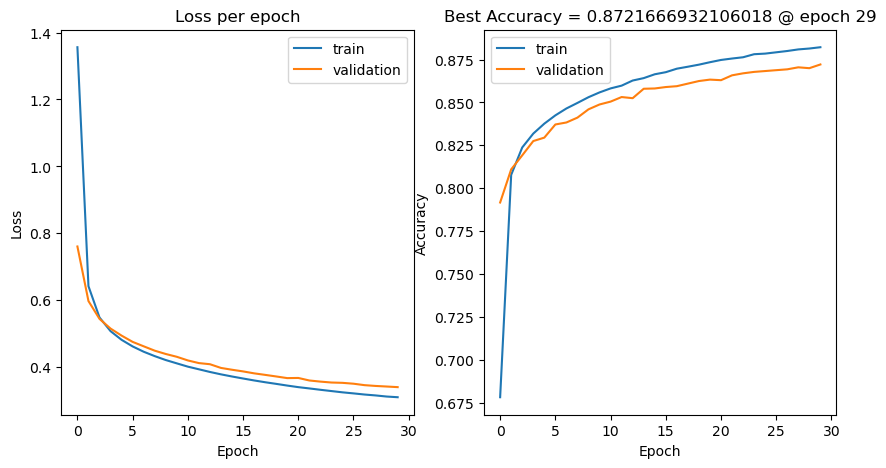

In [6]:
INPUT_SIZE = 32*32

# Training hyperparameters.
trainer_hparams={
    "epochs":30,
    "lr":0.0001,
    "batch_size":128
}

# Architecture hyperparameters.
arch_hparams={
    "width":100,
    "depth":2
}

config = {**trainer_hparams,**arch_hparams}
print(config)

writer = wandb.init(project=wandb_config['project'],config=config,mode='disabled')
# Define a DataLoader for MNIST with train and validation split

# Instantiate model and optimizer.
config = writer.config
model_mlp = MLP([INPUT_SIZE] + [config.width]*config.depth + [10]).to(DEVICE)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)
# Begin training
trainer = Trainer(opt,writer,epochs=config.epochs,device=DEVICE, checkpoints=True, **wandb_config)
train_log, val_log = trainer.train(model_mlp,train_data_loader,valid_data_loader)
# plot train and validation logs
plot_curves(train_log,val_log)

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

#### CIFAR-10 Data preparation
Here I define my dataset for CIFAR-10. Input images are per-pixel normalized along every channel. Mean and std are computed with the following code

In [110]:
# Load CIFAR train set
cifar_ds = datasets.CIFAR10(root='/data',train=True,download=True)
# Compute mean and std
mean = np.mean(cifar_ds.data, axis=(0,1,2))/255
std = np.std(cifar_ds.data, axis=(0,1,2))/255
print(f"Mean: {mean} - std: {std}")

Files already downloaded and verified
Mean: [0.49139968 0.48215841 0.44653091] - std: [0.24703223 0.24348513 0.26158784]


##### Data augmentation
Data augmentation is performed as in the paper
- The 32x32 is padded with 4 pixel on each side
- A random crop of 32x32 is taken from the padded image or its horizontal flip

Validation is 10% of training dataset. On this set, I only perform per-pixel normalization

In [111]:
# normalize data based on train split
normalize = transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
# Data augmentation and normalization for training
# Just normalization for validation
transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]),
}

# Split train into train and validation.
val_size = int(0.1 * len(cifar_ds))
I = np.random.permutation(len(cifar_ds))

cifar_val = SubsetDataset(Subset(cifar_ds, I[:val_size]), transform['val'])
cifar_train = SubsetDataset(Subset(cifar_ds, I[val_size:]), transform['train'])

cifar_train_loader = DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=True)
cifar_val_loader = DataLoader(cifar_val, batch_size=BATCH_SIZE)

To make sure that the the images and labels are in the correct format let's display a few samples. We can see that the images are not centered anymore due to the data augmentation procedure.

torch.Size([128, 3, 32, 32]) torch.Size([128])


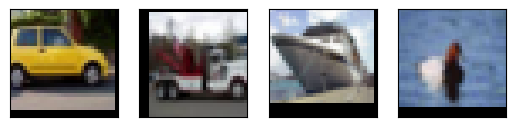

In [112]:
dataiter = iter(cifar_train_loader)
images,labels = next(dataiter)
# unnormalize images
images = images * std[:,None,None] + mean[:,None,None]
print(images.shape, labels.shape)
# show images
show(images[0:4])

#### Model definition
Here I define the convolutional network, which follows the ResNet definition of the paper for CIFAR-10.
The network is composed by an initial $3\times3$ convolutional layer, followed by a stack of $6n$ layers with $3 \times 3$ convolutions on feature maps of sizes {32,16,8}, with $2n$ layers for each feature map size.
The number of filters is doubled every time the size of the feature map is halved, to mantain the same number of operations.


| Output map size | 32 x 32 | 16 x 16 | 8 x 8 |
|-----------------|---------|---------|-------|
| # layers        | 1 + 2n  | 2n      | 2n    |
| # filters       | 16      | 32      | 64    |

##### Residual Block
To allow an easy modification of the model's depth and enabling/disabling residual connections, I created a `ResidualBlock` Module, which allows to add blocks of two convolutional layers to the network.
- The block consists of two convolutional layers, each followed by a Batch Normalization Layer before the ReLU activation.
- Downsampling is obtained with a strided convolution performed by the first convolutional layer.
- The residual connection is obtained by summing the input feature maps before the second nonlinearity. Since summmation is allowed only if the feature maps have the same shape, a projection layer is added to the residual connection when downsampling is performed.

##### Projection
The paper experiments with three types of projection. I provide an implementation of all three
    A) Parameter-free projection, performed by downsampling the input feature map and padding the remaining channels with zeros
    B) Paremeterized projection with an affine trasformation, followed by a Batch Normalization layer.
    C) Add a parameterized projection to all residual connections

##### Global Average Pooling
The ResNet use a Global Average Pooling layer followed by a Fully connected layer, as defined in [[2](https://arxiv.org/pdf/1312.4400.pdf)]. The Global Average Pooling transforms a feature map $H \times W \times C$ into $1 \times 1 \times C$.
If $C = $ num_classes, the resulting tensor could be directly fed into a softmax for prediction, however we employ a single Fully Connected layer, as done in the paper.

##### Initialization


In [10]:
arch_hparams = {
    "layers": [3] * 3,
    "residual": True,
    "batchnorm": True,
    "num_classes": 10,
    "num_channels": 16,
    "residual_type": 'a'
}

model = ResNetForClassification(**arch_hparams).to(DEVICE)
print(model)

ResNetForClassification(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

#### Training
We can now train convolutional models with and without residual connections.
- Used SGD optimizer, since it usually allows better results [[1](https://arxiv.org/pdf/1705.08292.pdf)], but needs to be trained for more epochs than Adam.
- Following the paper, I used a momentum of 0.9 and a weight decay of $10^{-4}$.
- The learning rate is initially set as 0.1 and divided by 10 at epochs 50 and 75, and training ends at epoch 85.

I trained models, with 3, 5 and 9 blocks per layer, leading to 20, 32 and 56 layer architectures, without residual connections (*plain*) or with residual connections (*residual*)
Training logs are available [here](https://wandb.ai/dla-darcio/lab-1-resnets) or by executing in terminal:

```bash
wandb dla-darcio/lab-1-resnets
```

Models were trained by executing the following command in terminal:

```bash
python train.py --num_layers <number of layers per block> --<residual | no-residual> --batchnorm --checkpoints
```

#### Experimental results
A full report on the results is available [here](https://wandb.ai/dla-darcio/lab-1-resnets/reports/Lab-1-Residual-Networks--Vmlldzo0MzQxMTIx).

We can see that deeper networks without residual connections (dashed lines) obtain a lower accuracy than shallower plain networks. The 56-layer newtork starts to exhibit large fluctuations in the accuracy and loss, which may be a linked to a bad optimization process and achieves a -3.4% accuracy compared to the 20-Layer plain network.

In contrast, deeper residual networks (continuous lines) exhibit a better performance than shallower ones, with the 56-Layer architecture achieving a +1.5% accuracy compared to the 20-Layer architecture.

![Accuracy](./assets/plain_res_accuracy.png)

##### We need to go deeper
As stated by the famous [meme](https://knowyourmeme.com/memes/we-need-to-go-deeper), I tried additional, deeper configurations, such as a 101-layer configuration and a 152-layer configuration to verify if deeper residual networks perform worse, and explain why.

In this case we can see that the 56-layer and the 101-layer configuration achieve similar results, with the 101-layer configuration leading to a slightly better accuracy (+0.2%).
The 152-layer configuration, however, leads to a lower accuracy than the 56-layer configuration (-0.5%).


![Accuracy](./assets/deep_res_accuracy.png)

Looking at the loss on the validation set, we see that for 101-layer and 152-layer configuration the loss starts to rise again after a certain number of epochs, which is a sign of overfitting.
We can thus attribute the lower accuracy of the 152-layer configuration to overfitting.


![Loss](./assets/deep_res_loss.png)

##### Test Results
These are the results obtained by the models trained in this section on the test set.
The better model is the Resnet-56, which achieves a 90% accuracy.

| Layers | Residual | Parameters | Accuracy  |
|:------:|:--------:|:----------:|:---------:|
|   20   |   Yes    |    270K    |   0.872   |
|   20   |    No    |    270K    |   0.867   |
|   56   |   Yes    |    835K    | **0.900** |
|   56   |    No    |    835K    |   0.839   |

-----
## Exercise 2 - Localization and Class Activation Maps with Fully convolutional ResNets
In this exercise I employed a Fully Convolutionalized ResNet to both calculate Class Activation Maps and perform object localization, following the procedure described in the paper [Learning Deep Features for Discriminative Localization](https://arxiv.org/pdf/1512.04150.pdf).

### Exercise 2.2 - MNIST Object localization with Fully-convolutionalized model
This experiment uses a fully-convolutionalized ResNet to perform *object localization* on MNIST. This was chosen over *detection* since
  - I would need to slightly change the training procedure
  - I would need to find additional hyperparameters (e.g. the threshold for the detection) and evaluate both precision and recall.
  - I would need a more elaborate procedure to build the dataset, since I would need to generate images with multiple digits.

#### Fully-convolutional model definition
To make a fully-convolutional model, I changed the ResNet architecture in the following ways:
- Associate one feature map to each of the dataset classes. To achieve this, I used a 1x1 convolution to pass from 64 to 10 feature maps, which are then downsampled with a Global Average Pooling layer. The obtained feature maps are then passed to a 2D softmax to obtain a probability map for each class.
- Removed the last fully-connected layer and replaced it with a 1x1 Global Average Pooling layer to calculate the spatial average of each feature map.

I created a new class `FullyConvResNet` that inherits from `ResNet`, and defining two methods:
- A standard `forward` method to perform classification
- A `localize` method to perform classification + localization, returning the logits and the feature map after Global Average Pooling

The localization method generates a feature map of dimension $(\text{mapping_size} \times \text{mapping_size})$ using Global Average Pooling, which is then transformed into a map of pixel-level probabilities of each class using a two-dimensional softmax `Softmax2d`.
Since the network performs downsampling of the input image, this map is smaller than the input image, so each element in this map is associated to a region of the input image.

#### Global Average Pooling
Global Average Pooling is implemented with the `nn.AdaptiveAvgPool2d` module, which allows to specify the output size of the pooling operation.

To perform classification we can use a 1x1 output size, calculating the mean across the whole image of the activations

![Global Average Pooling for classification](./assets/global_average_pooling.png)

To perform localization we can use a larger output size, which will generate a feature map of the specified size it was shown in the CAM paper that a larger output size leads to better localization results, so I used a 16x16 output size.

#### Data Loading
To generate the training data, I created a function `embed_image` to embed the MNIST digits into a larger image of size $128 \times 128$.
The dimension of the larger image was chosen to be large enough to allow the network to perform downsampling and retain a dimension that allows a reasonable localization, but not too large to reduce the computational cost.
The output feature map of the last convolutional layer will be of size $32 \times 32$ and it is resized to $16 \times 16$ by the Global Average Pooling layer.

This `embed_image` randomly selects a position in the larger image and copies the digit into that position.

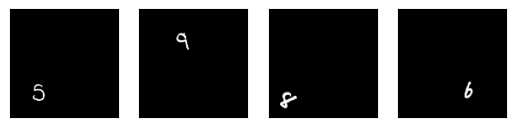

In [105]:
AUG_SIZE = 128

def embed_image(img):
    channels, width, height = img.shape
    new_img = torch.zeros((channels,AUG_SIZE, AUG_SIZE))
    x_min, y_min = randrange(AUG_SIZE - width), randrange(AUG_SIZE - height)
    x_max, y_max = x_min + width, y_min + height
    new_img[:,x_min:x_max, y_min:y_max] = img
    # print(new_img.shape)
    return new_img

# Load MNIST train dataset
dataset = datasets.MNIST(root='/data',train=True,download=True)
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    embed_image
])
# Split train into train and validation. We use 10% of the training data as validation
val_size = int(0.1*len(dataset))
I = np.random.permutation(len(dataset))

mnist_train = SubsetDataset(Subset(dataset, I[val_size:]),transform)
mnist_val = SubsetDataset(Subset(dataset, I[:val_size]),transform)

train_data_loader = DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True)
valid_data_loader = DataLoader(mnist_val,batch_size=BATCH_SIZE)

dataiter = iter(valid_data_loader)
images,labels = next(dataiter)
images, labels = images[0:4], labels[0:4]

show(images)

#### Training
The model is trained with the same procedure seen before on the classification task on MNIST.
This time it will be more difficult to classify the digits, since most of the image is mostly empty.
- The model was trained for 10 epochs, with a batch size of 128.
- Adam was chosen over SGD this time since it converges faster.
- A simple ResNet with 1 residual block for each layer was used (8 layers in total), since it was enough to achieve acceptable results.

Epoch 5: 100%|██████████| 422/422 [32:41<00:00,  4.65s/it, step_acc=0.992, step_loss=0.0516, train_acc=0.982, train_loss=0.0857, valid_acc=0.823, valid_loss=0.522]


FullyConvResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (project): DownsampleA(
        (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
      )
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-

Epoch 10: 100%|██████████| 422/422 [01:36<00:00,  4.56it/s, step_acc=0.953, step_loss=0.337, train_acc=0.962, train_loss=0.43, valid_acc=0.964, valid_loss=0.384]

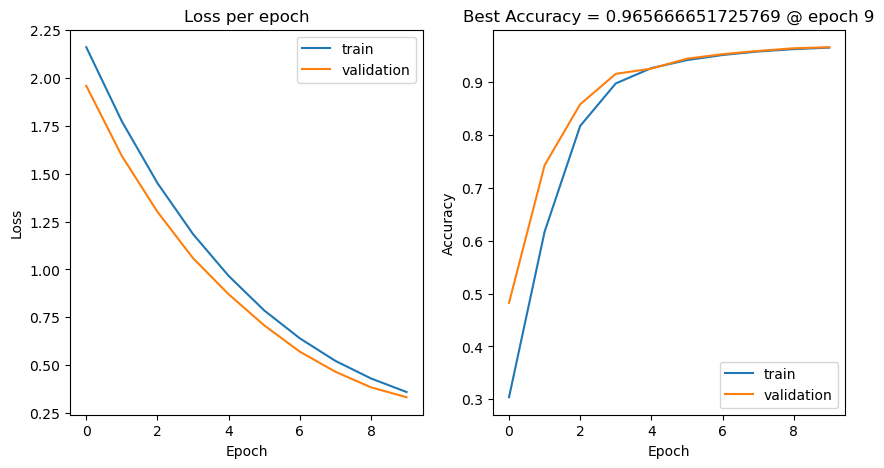

In [97]:
from models.resnet import FullyConvResNet

wandb.login()

wandb_config = {
    "project":"lab-1",
    "job_type": "model_trainer",
    "dataset_name": "MNIST-Localization",
    "model_collection_name": "MNIST Fully-conv ResNet"
}

# Training hyperparameters.
optimizer_hparams={
    "lr":1e-4
    #"weight_decay": 1e-4,
}

# Architecture hyperparameters.
arch_hparams={
    "layers":[1]*3,
    "residual": True,
    "num_classes":10,
    "num_channels": 16,
    "residual_type": 'a',
    "grayscale": True
}

config = {
    "optimizer": "Adam",
    "epochs":10,
    **optimizer_hparams,
    **arch_hparams
}

# Initialize WandB logging all hyperparameters
writer = wandb.init(project=wandb_config['project'],config=config,mode='disabled')
config = wandb.config

# Initialize model
model = FullyConvResNet(**arch_hparams).to(DEVICE)
print(model)

# Get optimizer from torch.optim
opt = getattr(torch.optim,config.optimizer)(params=model.parameters(), **optimizer_hparams)

# Begin training
trainer = Trainer(opt,writer,epochs=config.epochs,device=DEVICE,checkpoints=True, **wandb_config)
train_log, val_log = trainer.train(model,train_data_loader,valid_data_loader)
# plot train logs
plot_curves(train_log,val_log)

#### Class Activation Map
Class Activation Maps are a way to visualize the regions of an image that are used by a CNN to classify a certain class.
To do so, we can extract the features from the last convolutional layer and perform a weighted sum of the feature map corresponding to each class.
I used the outputs of the softmax as weights for the weighed sum. The resulting feature map is then upsampled to the original image size and plotted as a heatmap.

![Class Activation Map](./assets/class_activation_map.png)

#### Localization
To perform localization with the trained classifier, we extract the class activation map and use it to generate a heatmap of the same size as the input image.
Since the network performs downsampling during the forward pass, the mapping_size is smaller than the image size. To obtain the bounding box coordinates, we should associate each pixel of this probability map to a set of pixels in the original image.

To simplify this process, I just resized the heatmap to the original image size. There may be better solutions (ex. perform a segmentation or use detection approaches based on anchor boxes), but this one is simple and works well enough.

The plotted images should resemble a heatmap of the predicted probability for each pixel. By thresholding the heatmap, we can obtain a binary mask of the predicted pixels for the digit.
Instead of using a hard threshold, I followed the approach described in the paper and used the top 20% of the pixels with highest probability for each image in the batch.

In [102]:
def get_cam(probs, features):
    resize = torchvision.transforms.Resize(SIZE_UPSAMPLE, interpolation=InterpolationMode.BILINEAR,antialias=False)
    cam = torch.mul(probs[:,:,None,None], features).sum(dim=1, keepdim=True)
    cam = resize(cam)
    cam_img = cam - torch.min(cam)
    cam_img = cam_img / torch.max(cam)
    cam_img = (255 * cam_img).type(torch.uint8)
    return cam, cam_img

def threshold(mask):
    max = torch.amax(mask, dim=(2,3))
    mask = mask/max[:,:,None,None] > 0.8
    mask = mask.type(torch.uint8)
    return mask

Here we can see the probability map extracted from the feature maps after global average pooling. This map is not very precise for several reasons:
- The network is not trained to perform localization, so the feature maps are not optimized for this task.
- The probability map is upsampled to the input size dimension, but it is a quite rough approximation, since the downsampling maps an entire region of pixels to a single number in the feature map.

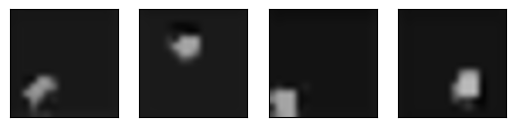

In [106]:
# get logits and activation map
SIZE_UPSAMPLE = (32,32)
# get logits and global average pooling of features
logits, gap = model.localize(images.to(DEVICE))
probs = F.softmax(logits.squeeze(),dim=1)

cam, cam_img = get_cam(probs, gap)

# seg_map = seg_map.unsqueeze(0).unsqueeze(0)

resize = torchvision.transforms.Resize(AUG_SIZE, interpolation=InterpolationMode.BICUBIC, antialias=True)

masks = resize(cam).detach().cpu()
show(masks)

#### Bounding Boxes
To transform the heatmap into a bounding box, I used the `masks_to_boxes` function from `torchvision.ops`.
This function returns the coordinates of the bounding box resulting from the binary mask, simply by taking the minimum and maximum coordinates of the mask along the two dimensions.

The network is not trained to perform localization but classification, so the bounding boxes do not always include the whole number or are not always tight around the number.
I believe that it happens because the network does not need to produce an accurate description of the whole number to perform classification.

Anyways, the features extracted by the network for the classification task localize the digit well enough in the larger image, resulting in a bounding box that includes at least part of the number.

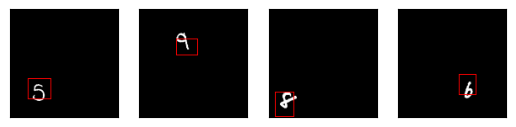

In [107]:
from torchvision.ops import masks_to_boxes
# apply threshold
masks = threshold(masks)
# transform masks to bounding boxes
boxes = masks_to_boxes(masks.squeeze())

drawn_boxes = []
for i in range(images.shape[0]):
    img = images[i]
    img = img * 255
    drawn_boxes.append(draw_bounding_boxes(img.type(torch.uint8), boxes[i].unsqueeze(0), colors="red"))
show(drawn_boxes)

### Exercise 2.3: *Explain* the predictions of a CNN

In this exercise I implemented [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.) for a trained ResNet-56 model on CIFAR-10.

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

I took a trained ResNet-56 model from exercise 1.2 and used the backbone weights, removing the last fully connected layer and substituting with a global average pooling layer, using the same network structure seen in the previous exercise.
Since the channels for the last convolutional layer are different from the number of classes, I added a 1x1 convolutional layer to reduce the number of channels to 10 and retrained only this layer for 10 epochs.

Interestingly, this network reaches 97% accuracy on the validation set, which is higher than previously found, but only 89.8% on the test set, which is 0.2% lower than the ResNet-56 trained in exercise 1.2.

{'optimizer': 'SGD', 'epochs': 85, 'lr': 0.1, 'wd': 0.0001, 'momentum': 0.9, 'layers': [9, 9, 9], 'residual': True, 'batchnorm': True, 'num_classes': 10, 'num_channels': 16, 'residual_type': 'a'}


Epoch 10: 100%|█████████▉| 351/352 [00:42<00:00,  8.32it/s, step_acc=0.984, step_loss=0.0645, train_acc=0.964, train_loss=0.106, valid_acc=0.976, valid_loss=0.084]

train_accuracy,▁▆▅▅▇▆▅▆▅▄▇▅▅▃▅▇▇▆▅▅█▅▅▅▅▅▅▇▅▅▅▇▇▇▄▇▇▇▄▇
train_loss,█▃▄▃▂▃▂▂▂▃▁▃▃▃▃▂▁▃▄▃▁▄▃▃▃▃▂▂▂▃▃▁▂▂▃▂▂▁▃▂
val_acc,▅▄█▂▇▁▃▆▇▆
val_loss,█▃▃▅▁▃▄▃▅▂
train_accuracy,0.98438
train_loss,0.0645
val_acc,0.976
val_loss,0.07973


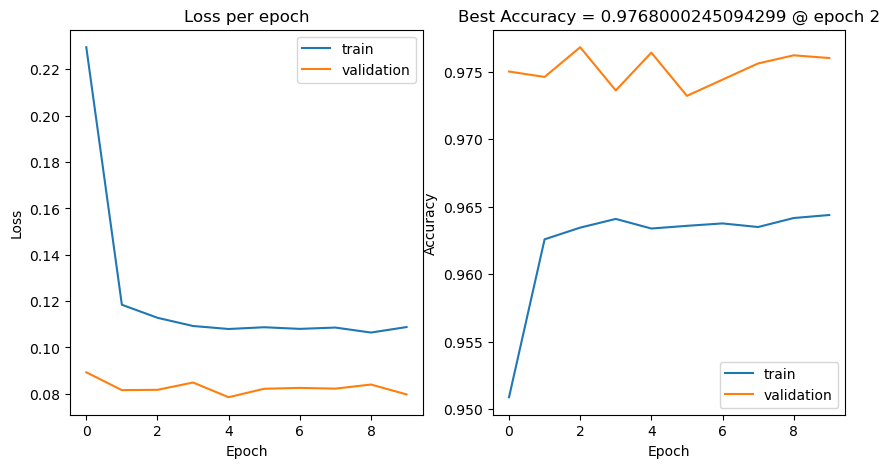

In [48]:
from torch.optim import Adam
from models.resnet import FullyConvResNet

# Best ResNet-56 checkpoint
ckpt_url = 'dla-darcio/lab-1-resnets/cifar10-rhhhe6tv:best'
# Already trained FullyConvResNet
# ckpt_url = 'dla-darcio/DLA-lab1/cifar-7rfjxp0j:v9'

# Training hyperparameters.
optimizer_hparams={
    "lr":1e-3
    #"weight_decay": 1e-4,
}

# Architecture hyperparameters.
arch_hparams={
    "layers":[9]*3,
    "residual": True,
    "batchnorm": True,
    "num_classes":10,
    "num_channels": 16,
    "residual_type": 'a'
}

config = {
    "optimizer": "Adam",
    "epochs":5,
    **optimizer_hparams,
    **arch_hparams
}

run = wandb.init(mode='online')

model_art = wandb.use_artifact(ckpt_url)
model_path = model_art.get_path("ckpt-best.pth").download()
ckpt = torch.load(model_path, map_location=DEVICE)
# this ignores console params
arch_hparams.update((k, config[k]) for k in config.keys() & arch_hparams.keys())
model = FullyConvResNet(**arch_hparams).to(DEVICE)
state_dict = ckpt['state_dict']
model.load_state_dict(state_dict, strict=False)

# Freeze layers
model.conv1.requires_grad_(False)
model.layer1.requires_grad_(False)
model.layer2.requires_grad_(False)
model.layer3.requires_grad_(False)

# Get optimizer from torch.optim
opt = Adam(params=model.parameters(), lr=1e-2)
# Begin training
trainer = Trainer(opt,run,epochs=10,device=DEVICE,checkpoints=True, **wandb_config)
train_log, val_log = trainer.train(model,cifar_train_loader,cifar_val_loader)
# plot train logs
plot_curves(train_log,val_log)

torch.Size([128, 3, 32, 32]) torch.Size([128])


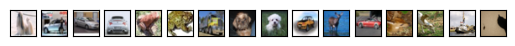

In [127]:
N_IMGS = 16

dataiter = iter(cifar_val_loader)
images,labels = next(dataiter)
images = images * std[:,None,None] + mean[:,None,None]
print(images.shape, labels.shape)
# show images
show(images[:N_IMGS,:,:,:])

#### Class Activation Maps
The implemented ResNet architecture performed down-sampling by a factor of 8, so the obtained CAMs were 8 times smaller than the input image. That means that the CAMs were 4x4 images, which were too small to provide a detailed information. To solve this problem, I redefined the network to perform down-sampling by a factor of 2, which resulted in CAMs of size 16x16.

In [125]:
class FullyConvResNet(ResNet):
    def __init__(self,layers, num_classes: int = 10, mapping_size = 16, num_channels=16, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.project = nn.Conv2d(self.num_channels,num_classes,1)
        self.classifier = nn.AdaptiveAvgPool2d(1)
        # Someway limits
        self.map = nn.AdaptiveAvgPool2d(mapping_size)
        self.s2d = nn.Softmax2d()
        self.layer1 = self._add_block(in_channels=num_channels, out_channels=num_channels, n_blocks=layers[0], stride=2)
        num_channels *= 2
        self.layer2 = self._add_block(num_channels // 2, num_channels, layers[1], stride=1)
        num_channels *= 2
        self.layer3 = self._add_block(num_channels // 2, num_channels, layers[2], stride=1)
        self.num_channels = num_channels

    def forward(self, x):
        out = super().forward(x)
        out = self.project(out)
        logits = self.classifier(out)
        return logits.squeeze()

    def localize(self, x):
        out = super().forward(x)
        out = self.project(out)
        # compute classification
        logits = self.classifier(out)
        # compute activation map
        mapping = self.map(out)
        return logits, self.s2d(mapping)

# Best ResNet-56 checkpoint
# ckpt_url = 'dla-darcio/lab-1-resnets/cifar10-rhhhe6tv:best'
# Already trained FullyConvResNet
ckpt_url = 'dla-darcio/DLA-lab1/cifar-7rfjxp0j:v9'

# Training hyperparameters.
optimizer_hparams={
    "lr":1e-3
    #"weight_decay": 1e-4,
}

# Architecture hyperparameters.
arch_hparams={
    "layers":[9]*3,
    "residual": True,
    "batchnorm": True,
    "num_classes":10,
    "mapping_size": 16,
    "num_channels": 16,
    "residual_type": 'a'
}

config = {
    "optimizer": "Adam",
    "epochs":5,
    **optimizer_hparams,
    **arch_hparams
}

run = wandb.init(mode='online')

model_art = wandb.use_artifact(ckpt_url)
model_path = model_art.get_path("ckpt-best.pth").download()
ckpt = torch.load(model_path, map_location=DEVICE)
# this ignores console params
arch_hparams.update((k, config[k]) for k in config.keys() & arch_hparams.keys())
model = FullyConvResNet(**arch_hparams).to(DEVICE)
state_dict = ckpt['state_dict']
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

<All keys matched successfully>

We can now visualize the CAMs for the first 16 images of the validation set.
The following points emerge:
- When the prediction is perfomed with high confidence, the CAM is very clear and the network is focusing on the correct region of the image.
- When the prediction is uncertain, the CAM does not show a clear difference between the image regions

We can see some empirical differences between classes:
- For the class "airplane", the network focuses on the wings, but also on the background, which is light blue in most of the images. Similarly, for the class "boat" the network focuses on the higher part of the boat, but also on certain regions of the sea.
- For the class "automobile", the network focuses on the wheels or other details of the car
- For the class "dog", the network focuses on the head and the dog ears
- The class "frog" shows a very clear activation, with the network focusing on the whole body.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 7 | True: 5 | Prob: 0.36280


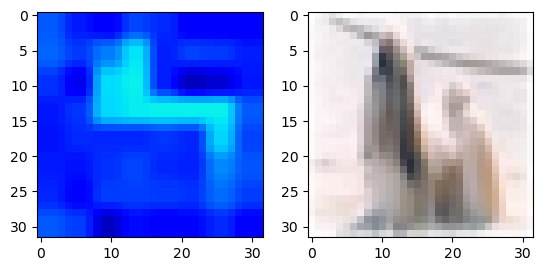

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 8 | True: 1 | Prob: 0.76284


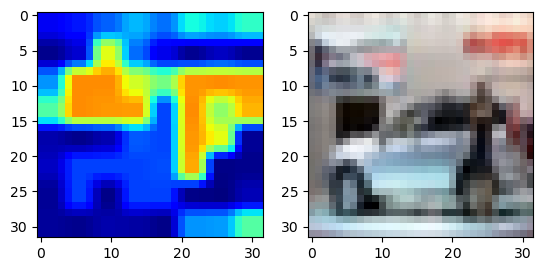

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 3 | True: 1 | Prob: 0.70129


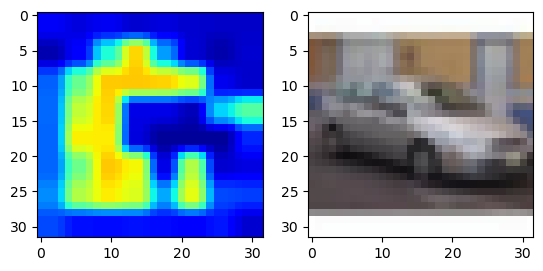

Predicted: 8 | True: 1 | Prob: 0.97594


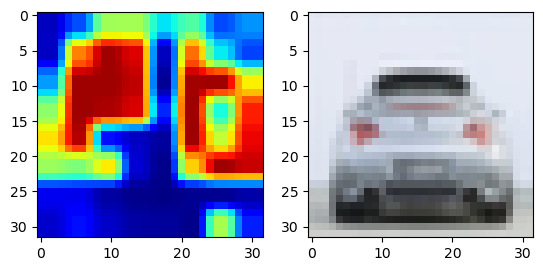

Predicted: 6 | True: 6 | Prob: 0.27001


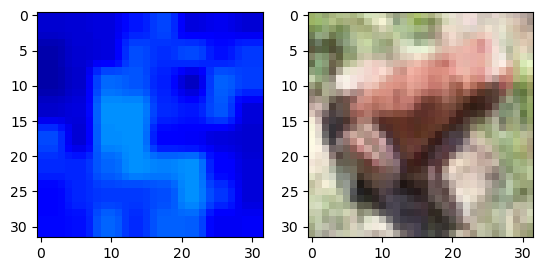

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 6 | True: 6 | Prob: 0.99952


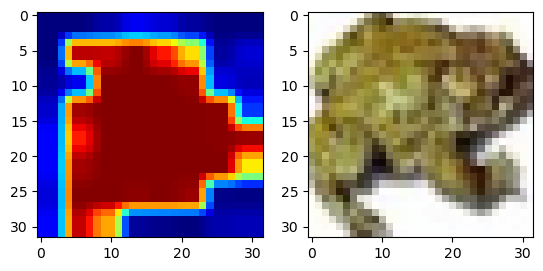

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 9 | True: 9 | Prob: 0.49023


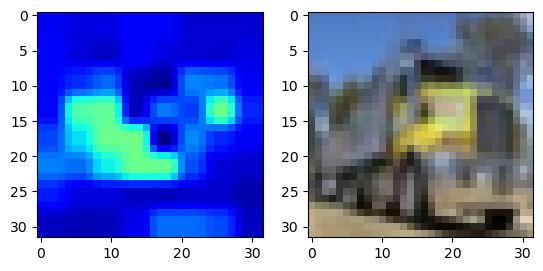

Predicted: 3 | True: 5 | Prob: 0.54877


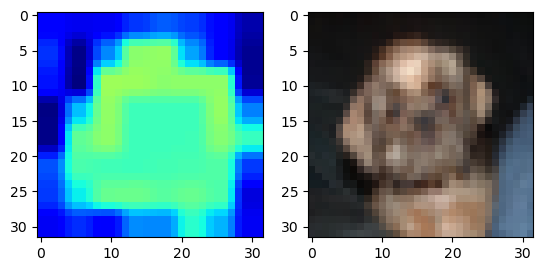

Predicted: 5 | True: 5 | Prob: 0.99458


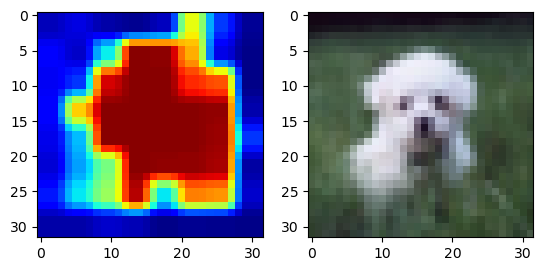

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 8 | True: 1 | Prob: 0.45895


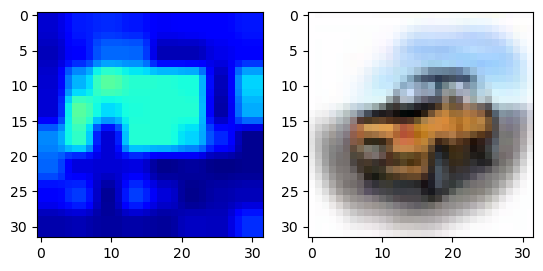

Predicted: 4 | True: 4 | Prob: 0.99547


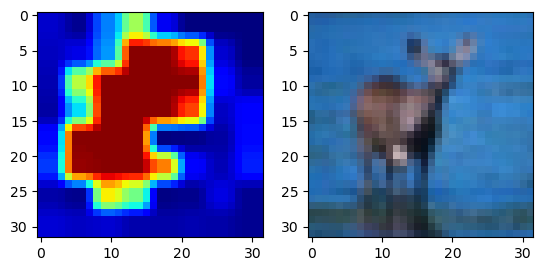

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 3 | True: 1 | Prob: 0.43784


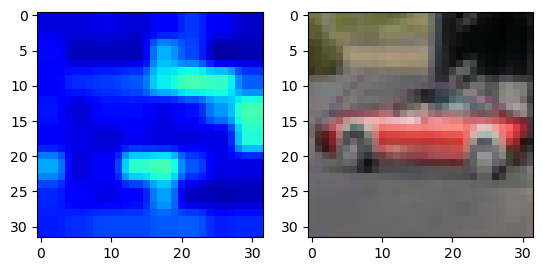

Predicted: 3 | True: 4 | Prob: 0.93079


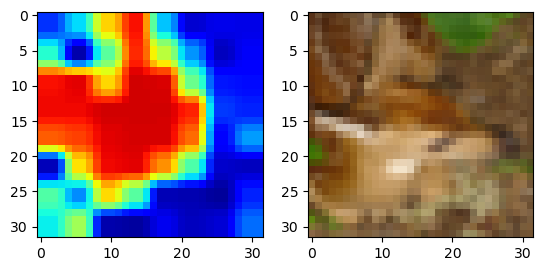

Predicted: 3 | True: 4 | Prob: 0.49515


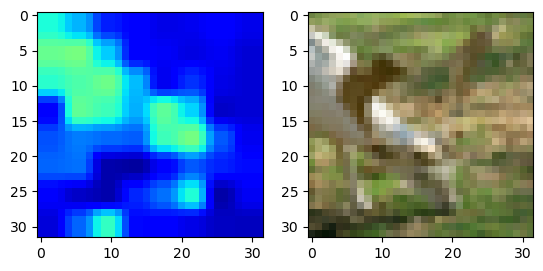

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 8 | True: 8 | Prob: 0.98487


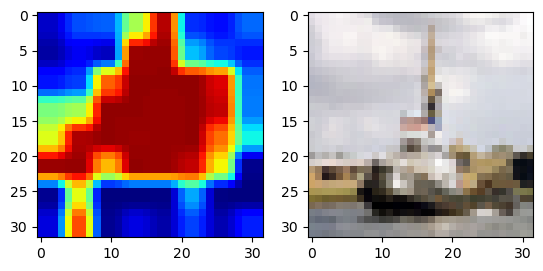

Predicted: 3 | True: 3 | Prob: 0.40151


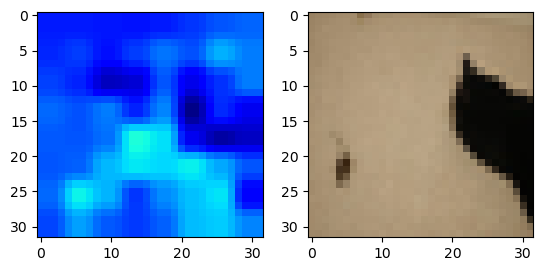

In [129]:
SIZE_UPSAMPLE = (32,32)
# Calculate CAM
model.eval()


logits, feature_maps = model.localize(images.to(DEVICE).type(torch.float)) # get the feature maps of the last convolutional layer
feature_maps = feature_maps.detach().cpu()

probs = F.softmax(logits, dim=1).detach().cpu() # get the probabilities of the classes
cam, cam_img = get_cam(probs, feature_maps) # generate the CAM for the input image
# one-hot the highest probability class
classes = torch.argmax(probs,dim=1)
from matplotlib import cm

jet = matplotlib.colormaps['jet']
heatmap = jet(cam_img)
heatmap = heatmap[:N_IMGS]
for i,h in enumerate(heatmap):
    plt.subplot(1,2,1)
    print(f'Predicted: {classes[i]} | True: {labels[i]} | Prob: {probs[i,classes[i]]:.5f}')
    plt.imshow(h.squeeze(), cmap='jet')
    plt.subplot(1,2,2)
    plt.imshow(images[i].transpose(0,2).transpose(0,1))
    plt.show()

## References
- [1] [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.
- [2] [Gradient-based learning applied to document recognition](https://ieeexplore.ieee.org/abstract/document/726791?casa_token=2f3TWz1uWI0AAAAA:SoY6RkquBPYqPV8iXkvTyqQZtcpxg5Czo5b5yyXEVXsusnQ17pMMnMgdZepox-H9zRWaHVpJ) LeCun, Yann, et al. Proceedings of the IEEE 86.11 (1998): 2278-2324.
- [3] [The Marginal Value of Adaptive Gradient Methods in Machine Learning](https://proceedings.neurips.cc/paper/2017/hash/81b3833e2504647f9d794f7d7b9bf341-Abstract.html) Ashia C. Wilson, Rebecca Roelofs, Mitchell Stern, Nathan Srebro, and Benjamin Recht. , 2018.
- [4] [Network in network](https://arxiv.org/abs/1312.4400) Lin, Min, Qiang Chen, and Shuicheng Yan. arXiv preprint arXiv:1312.4400 (2013).
- [5] [Learning Deep Features for Discriminative Localization](https://arxiv.org/pdf/1512.04150.pdf) B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba.  CVPR'16 (arXiv:1512.04150, 2015)
